# Data Cleaning

In this part, I replaced the missing value and applied one-hot encoding and label encoding to deal with the categorical data.

The KEY insight on the dataset is that the positive (i.e. fraud) and negative samples are highly imbalanced.

In [1]:
import os

import numpy as np
import pandas as pd

The overall dataset consists of the identity data and transaction data. To have a holistic view of each transaction, I combined the two datasets.

In [54]:
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')

train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
x_train = train.drop(['isFraud'], axis=1)
submission = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(x_train.shape)
print(submission.shape)

(80397, 432)
(10000, 432)


### Missing Value

For categorical data, I used the forward fill method to fill in the missing value. Whereas for numeric data, I used the column mean to replace the missing value.

In [55]:
""" 
drop 'M6', 'dist1', 'D11', 'M2', 'M3', 'M5', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'  - all entries in these columns are nan in test dataset

drop uninformative columns: 'M1', 'M4', 'R_emaildomain'
"""
nan_col = ['M6', 'dist1', 'D11', 'M2', 'M3', 'M5', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'M1', 'M4', 'R_emaildomain']
x_train = x_train.drop(nan_col, axis=1)
submission = submission.drop(nan_col, axis=1)

# get all the categorical features
cat_x_train = x_train.select_dtypes(include=['object']).copy()
cat_col_name = cat_x_train.columns

# fill missing value using forward fill method - categorical data
for col_name in cat_col_name:
    x_train[col_name].fillna(method='ffill', inplace=True)
    submission[col_name].fillna(method='ffill', inplace=True)
    x_train[col_name].fillna(method='bfill', inplace=True)
    submission[col_name].fillna(method='bfill', inplace=True)


# fill all other missing value with mean - numeric data
all_col_names = x_train.columns
error_catcher = []
for col_name in all_col_names:
    try:
        x_train[col_name].fillna(x_train[col_name].mean(), inplace=True)
        submission[col_name].fillna(submission[col_name].mean(), inplace=True)
    except:
        error_catcher.append(col_name)


# drop the uninformaive columns
uninfo_col = ['id_30', 'id_33', 'DeviceInfo']
x_train = x_train.drop(uninfo_col, axis=1)
submission = submission.drop(uninfo_col, axis=1)

In [56]:
print("The number of missing value in x_train is ", x_train.isnull().sum().sum()) # missing value count
print("The number of missing value in submission is ", submission.isnull().sum().sum()) # missing value count
print(x_train.shape) # shape of dataset
print(submission.shape) # shape of dataset

The number of missing value in x_train is  0
The number of missing value in submission is  0
(80397, 406)
(10000, 406)


### Dealing with Categorical Data

I applied one-hot encoding to transform each distinct entry into dummy variables, and label-encoding to address the binary columns.

In [57]:
## categorical features
# one-hot encoding
onehot_col_name = ['ProductCD', 'P_emaildomain', 'card4', 'card6', 'DeviceType', 'id_15', 'id_23', 'id_28', 'id_31', 'id_34']

x_train = pd.get_dummies(x_train, columns=onehot_col_name, prefix = onehot_col_name)
submission = pd.get_dummies(submission, columns=onehot_col_name, prefix = onehot_col_name)

# label encoding
def label_encoding_TF(data, col):
    '''
    Feature consists of 'T' and 'F'

    label: 
    T - 1
    F - 0 
    '''
    replace_map = {col: {'T': 1, 'F': 0}} 
    data.replace(replace_map, inplace=True)

def label_encoding_found(data, col):
    '''
    Feature consists of 'NotFound' and 'Found'

    label: 
    NotFound - 0
    Found - 1
    '''
    replace_map = {col: {'NotFound': 0, 'Found': 1}} 
    data.replace(replace_map, inplace=True)

label_col_found = ['id_12', 'id_16', 'id_27', 'id_29'] # columns that consist of 'Found' and 'NotFound'
label_col_TF = ['id_35', 'id_36', 'id_37', 'id_38'] # columns that consist of 'T' and 'F'

for col_name in label_col_TF:
    label_encoding_TF(x_train, col_name)
    label_encoding_TF(submission, col_name)

for col_name in label_col_found:
    label_encoding_found(x_train, col_name)
    label_encoding_found(submission, col_name)

In [58]:
print(x_train.shape)
print(submission.shape)

(80397, 563)
(10000, 581)


We see that the number of features in x_train and submission is different. It is because when we apply one-hot encoding, the new features may be different since the entries in the categorical features may be different. Thus, action needed to maintain the number and order of the columns in two datasets.

In [59]:
train_col = x_train.columns
submission_col = submission.columns

new_col = [x for x in train_col if x not in submission_col] # length is 14
new_col_sub = [x for x in submission_col if x not in train_col] # length is 32

# add new columns to submission
for col in new_col:
    submission[col] = 0

# add new columns to x_train
for col in new_col_sub:
    x_train[col] = 0

# in order to sort the columns, I will create a new dataframe for submission
all_col_names = x_train.columns
submission_new = pd.DataFrame(index=submission.index,columns=all_col_names)
for col in all_col_names:
    submission_new[col] = submission[col].copy()

In [80]:
# attach the 'isFraud' column
x_train['isFraud'] = train['isFraud'].copy()

# save the processed dataset
x_train.to_csv('train_processed.csv', index = True, header=True)
submission_new.to_csv('submission_processed.csv', index = True, header=True)

# Modelling

In this part, I set up 6 classification models, i.e. KNN, Isolated Forest, Decision Tree, AdaBoost, XGBoost, and Random Forest Regressor. I compared the performance of each classification algorithm in terms of their accuracy and auroc score, and selected the best performed algorithm as the model for prediction. At the end of this notebook, I concluded some lessons learned from this project.

## Read in the Dataset
I read the processed dataset and split the labeled data to trainning set and test set.

In [2]:
# import the neccesary packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import math
import matplotlib.pyplot as plt

In [3]:
# read in the dataset
x_train = pd.read_csv('train_processed.csv')
submission = pd.read_csv('submission_processed.csv')

# split the training and test data
Y = x_train['isFraud']
X = x_train.drop(['isFraud'], axis = 1)

from sklearn.model_selection import train_test_split

# split training set and test set
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.3, random_state=31)

# numpy to matrix for easy processing
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## K Nearest Neighbors

For the KNN model, I first run the Grid search to find the best parameter (k & p). Then, I can use the parameter combination to train the trainning set.

In [ ]:
# Grid Search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'weights': ['uniform'],
        'n_neighbors': [i for i in range(1, 5)]
    },
    {
        'weights': ['distance'],
        'n_neighbors': [i for i in range(1, 5)],
        'p': [i for i in range(1, 4)]
    }
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, n_jobs= -1, verbose=2)
grid_search.fit(X_train, y_train)

# output the best parameter for KNN
grid_search.best_params_ # the best parameters for KNN is N = 4, p = 1

In [4]:
## trainning - KNN
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=4, weights="distance", p=1)
clf_knn.fit(X_train, y_train)

y_predict_knn = clf_knn.predict(X_test)

In [9]:
# Accuracy
accuracy_score(y_test, y_predict_knn) # accuracy is 0.975

0.9750829187396352

In [10]:
# AUROC score
roc_auc_score(y_test, y_predict_knn) # roc_auc is 0.57

0.5702224760299568

## Isolated Forest
Isolated Forest is an anomaly detction algorithm. In our fraud-detection project, the positive and negative samples are highly imbalanced. Thus, we can treat the fraud samples as anomalies, and apply Isolated Forest to detect the anomaly.

In [11]:
from sklearn.ensemble import IsolationForest
## Trainning - Isolated Forest
clf_if = IsolationForest(contamination = 0.15,n_estimators = 100,max_samples = 0.6,max_features = 0.6,random_state = 42)
clf_if.fit(X_train)

y_predict_if = pd.Series(clf_if.predict(X_test))
y_predict_if.replace(1,0,inplace = True)
y_predict_if.replace(-1,1,inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [12]:
# Accuracy
accuracy_score(y_test, y_predict_if) # accuracy is 0.847

0.8470149253731343

In [13]:
# AUROC score
roc_auc_score(y_test, y_predict_if) # roc_auc is 0.649

0.6468214089230399

## Decision Tree

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
## Trainning - Decision Tree
clf_dt = DecisionTreeClassifier(min_samples_leaf = 2,random_state=1)
clf_dt.fit(X_train, y_train)
y_predict_dt = clf_dt.predict(X_test)

In [6]:
# Accuracy
accuracy_score(y_test, y_predict_dt) # accuracy is 0.977

0.9769485903814262

In [7]:
# AUROC score
roc_auc_score(y_test, y_predict_dt) # roc_auc is 0.715

0.7150750627426301

<Figure size 432x288 with 0 Axes>

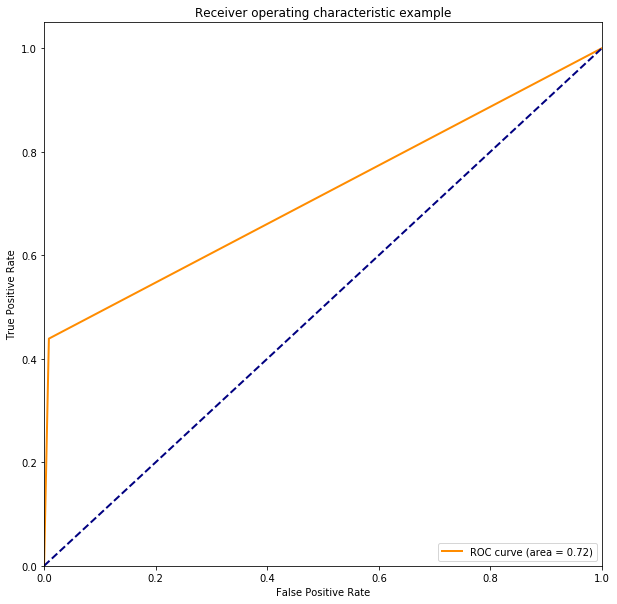

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_dt) # calculate false positive and true positive
roc_auc = auc(fpr,tpr) # auc


plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

## Adaboost

In [17]:
from sklearn.ensemble import AdaBoostClassifier
## Trainning - Adaboost
clf_adb = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200)
clf_adb.fit(X_train, y_train)
y_predict_adb = clf_adb.predict(X_test)

In [18]:
# Accuracy
accuracy_score(y_test, y_predict_adb) # accuracy is 0.979

0.9794776119402985

In [19]:
# AUROC score
roc_auc_score(y_test, y_predict_adb) # roc_auc is 0.651

0.6513886961004379

## XGBoost

In [5]:
from xgboost import XGBClassifier
## Training - XGBT
clf_xgbt = XGBClassifier()
clf_xgbt.fit(X_train, y_train)
pred_XGBT = clf_xgbt.predict(X_test)
y_predict_xgbt = [round(value) for value in pred_XGBT]

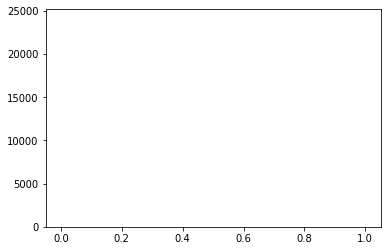

In [6]:
# histogram of the distribution
import matplotlib.pyplot as plt
plt.hist(pred_XGBT, bins = 1000)
plt.show()

As you can see from the graph, the distribution of the prediction by XGBT is gathered around 0 and 1. Thus, I can set any number between 0.1 and 0.9 as the threshold, and it will not affect the performance of the model.

In [21]:
# Accuracy
accuracy_score(y_test, y_predict_xgbt) # accuracy is 0.98

0.9803067993366501

In [22]:
# AUROC score
roc_auc_score(y_test, y_predict_xgbt) # roc_auc is 0.629

0.6293791844916555

<Figure size 432x288 with 0 Axes>

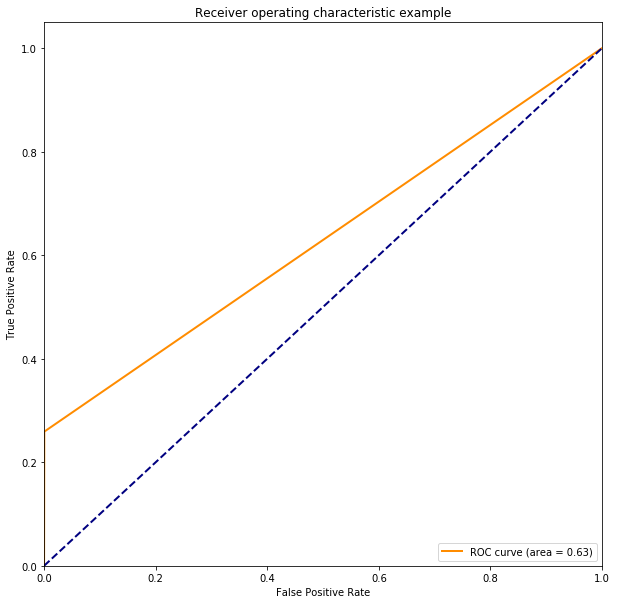

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred_XGBT) # calculate false positive and true positive
roc_auc = auc(fpr,tpr) # auc


plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

## Random Forest Regressor

The random forest regressor will output the probabilty (0-1) of each sample being fraud case. Thus, we need to find a threshold which distinguish the positive and negtive samples and yield the best result in terms of accuracy and auroc. 

In [27]:
from sklearn.ensemble import RandomForestRegressor
## Trainning - Random Forest
RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators= 1000, random_state=42)
clf_rf.fit(X_train, y_train)
y_predict_rf = clf_rf.predict(X_test)

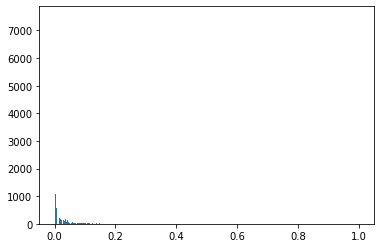

In [28]:
# histogram of the distribution
plt.hist(y_predict_rf, bins = 1000)
plt.show() # as we can see, the predicted probability spans from 0 to 0.2

In [38]:
results = []
threshold_options = list(np.arange (0.01, 0.16, 0.01))

for threshold in threshold_options:
    pred = [math.ceil(x) if x > threshold else 0 for x in y_predict_rf]
    acc = accuracy_score(y_test, pred) # accuracy
    auroc = roc_auc_score(y_test, pred) # auroc

    results.append([threshold, acc, auroc])

# 打印精度最大的那一个三元组
print(max(results, key=lambda x: x[2]))

[0.06999999999999999, 0.9274046434494195, 0.8312136793044376]


In [40]:
results

[[0.01, 0.7048092868988391, 0.7765052123266909],
 [0.02, 0.7952321724709784, 0.8066810622395113],
 [0.03, 0.8453150912106135, 0.819241364229808],
 [0.04, 0.880016583747927, 0.8269995362023097],
 [0.05, 0.9010364842454395, 0.826960113737027],
 [0.060000000000000005, 0.916542288557214, 0.830278842372335],
 [0.06999999999999999, 0.9274046434494195, 0.8312136793044376],
 [0.08, 0.9377694859038143, 0.8303458436438026],
 [0.09, 0.9455223880597015, 0.8227216742142358],
 [0.09999999999999999, 0.9514096185737977, 0.8218759692766008],
 [0.11, 0.9572553897180763, 0.8179144683425421],
 [0.12, 0.9614013266998341, 0.8123066649548631],
 [0.13, 0.9643449419568823, 0.810723370767643],
 [0.14, 0.9674543946932007, 0.8099988433820916],
 [0.15000000000000002, 0.969485903814262, 0.8048527735040968]]

From the above table, we can see when the threshold is 0.1, the accuracy is 0.951 and the auroc score is 0.822. And this is the best output among all the other algorithms. Thus, I will use random forest with threshold 0.1 as our model for prediction.

# Prediction

Random forest is the best performed algorithm in terms of the accuracy and auroc score. Thus, I will use random forest as the model for prediction.

In [41]:
# prediction
y_submission = clf_rf.predict(submission)
y_submission_01 = [math.ceil(x) if x > 0.1 else 0 for x in y_submission]

In [44]:
# Replace the submission file: newsample_submission.csv
newsample_submission = pd.read_csv('newsample_submission.csv')
# newsample_submission['isFraud'] = y_submission_01
newsample_submission['isFraud'] = y_submission

In [51]:
# save the prediction for submission
newsample_submission.to_csv('prediction_submission.csv', index = False)

# Lessons and Future Work

## Lessons
1. As we mentioned above, the dataset for this project is highly imbalanced. Therefore, there are few positive, i.e. fraud, samples for us to learn from. I found the following useful ways to dealing this this kind of imbalanced datset:

- Expand the dataset: Simply by increasing the size of the datset, we can immediatedly have more postive samples, which leads to better model.
- Try anomaly detection: Sometimes, the positive samples are too few that we can see them as anomaly. In this regards, we can use anomaly detection algorithms, such as isolated forest, to do the prediction. 
- Decision-tree type of algorithms: From the performance of the above algorithms, we can easily find that the decision-tree type of algorithms, such as decision tree algorithm and random forest regressor, perform the best among all algorithms in dealing with imbalanced dataset.

2. To optimize a given algorithm, we need to find the best combination of hyper-parameters which yields the best auroc score or accuracy. And this process is the most time consuming part because each time we change our parameters, we need to run the model again.

## Future Work
To furthur improve the auroc, the following are some suggestions:
- Oversamplling: Since the dataset is imbalanced, we can oversampl the positive samples to help our algorithms to learn from them.
- Parameter selection: After applying the one-hot encoding, there are many new features that do not carry much information. Thus, we can apply PCA or Lasso Regression to select the parameters.
- Hyper-parameter selectioin: Fitting the random forest model costs about 2 hours each time. Due to the time limit, I didn't try enough hyper-parameters for the random forest model. If time permitted, we can use the Grid Search algorithm to tune the hyper-parameters. 